# Dropout as Bayesian Approximation

\
<center>
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile23.uf.tistory.com%2Fimage%2F99DCCC3D5B87BF6D05D7D5' width=500>
</center>

In this paper Researchers develop a
new theoretical framework casting dropout training in deep neural networks (NNs) as approximate Bayesian inference in deep Gaussian processes. 

A direct result of this theory gives us
tools to model uncertainty with dropout NNs –
extracting information from existing models that
has been thrown away so far.

\

**Predictive Probability in GP**

$$
p(y|x^*, X, Y) = \int p(y|x^*, w) p(w|X, Y) dw
$$

$$
p(y|x, w) = \mathcal{N}(y; \hat{y}(x, w), \tau^{-1}I_D)
$$

$$
\hat{y}(x, w= \{ W_1, \cdots, W_L\}) = \sqrt\frac{1}{K_L}W_L\sigma( \cdots \sqrt\frac{1}{K_1}W_2 \sigma(W_1x + m_1) \cdots)
$$

\

**Objective by Variational inference**

$$
- \int q(w) \log p(Y|X, w) dw +KL(q(w) \rVert p(w)).
$$

\


**Model uncertainty**

$$
q(y^*|x^*) = \int p(y^*|x^*, w) q(w) dw
$$

$$
E_{q(y^*|x^*)}(y^*) = \frac{1}{T}\sum_{i=1}^T \hat{y}^*(x^*, W_1^t, \cdots, W_L^t)
$$

$$
E_{q(y^*|x^*)}((y^*) ^T y^*) \approx \tau^{-1}I_D +\frac{1}{T}\sum_{i=1}^T \hat{y}^*(x^*, W_1^t, \cdots, W_L^t) ^ T \hat{y}^*(x^*, W_1^t, \cdots, W_L^t)
$$

$$
Var_{q(y^*|x^*)}(y^*) \approx  \tau^{-1}I_D + \frac{1}{T}\sum_{i=1}^T \hat{y}^*(x^*, W_1^t, \cdots, W_L^t) ^ T \hat{y}^*(x^*, W_1^t, \cdots, W_L^t) -E_{q(y^*|x^*)}(y^*) ^T E_{q(y^*|x^*)}(y^*)
$$

\

**At Regression Task**


$$
\log p(y^*|x^*, X, Y) \approx \mathrm{logsumexp} ( -\frac{1}{2}\tau\rVert y - \hat{y}\rVert^2) -\log T - \frac{1}{2}2\pi - \frac{1}{2}\log \tau ^{-1}
$$

In [0]:
import torch
import torchvision
from torch import nn
import numpy as np
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.special import logsumexp

# Model


In [0]:
class Model(nn.Module):

    def __init__(self,
                 x_train: torch.Tensor,
                 y_train: torch.Tensor, 
                 input_dim: int, 
                 hidden_dim: int, 
                 output_dim: int, 
                 n_sample:int,
                 dropout:float,
                 tau: float
                 ):
        super(Model, self).__init__()
        self.n_sample = n_sample
        self.dropout = dropout
        self.tau = tau

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        self.x_train = x_train
        self.y_train = y_train
        self.mean_y_train, self.std_y_train = np.mean(y_train), np.std(y_train)

    def forward(self, x):
        return self.model(x)

    def predict(self, x_test: np.ndarray, y_test: np.ndarray):
        ''' Function for making predictions with the Bayesian neural network.'''
        outputs = np.array([self.model(torch.Tensor(x_test)).detach().numpy() for _ in range(self.n_sample)])
        yt_hat = outputs * self.std_y_train + self.mean_y_train
        pred_mean = np.mean(yt_hat, axis=0)
        mean_square = np.mean(yt_hat ** 2, axis=0) + self.tau
        pred_var = self.tau + np.mean(yt_hat ** 2 - mean_square ** 2, axis=0)
        rmse = np.mean((y_test.squeeze() - pred_mean.squeeze()) ** 2) ** 0.5
        ll = (logsumexp(-0.5 * self.tau * (y_test - yt_hat)**2., 0) - np.log(self.n_sample) 
            - 0.5*np.log(2*np.pi) + 0.5*np.log(self.tau))
        # test_ll = np.mean(ll)
        return pred_mean, pred_var, rmse, ll



# Dataset

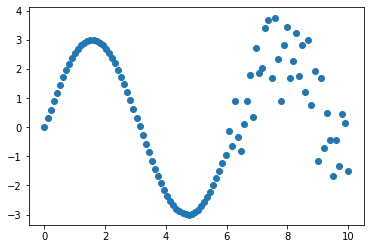

In [238]:
x_train = np.linspace(start=0, stop=10, num=100)
y_train = [np.sin(val) * 3 for val in x_train]

for i in range(len(y_train)):
    if i < 60: continue;
    y_train[i] += np.random.randn()

plt.scatter(x_train, y_train)
plt.show()

x_train = np.asarray([[val] for val in x_train])
y_train = np.asarray([[val] for val in y_train])

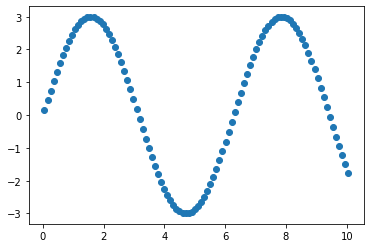

In [239]:
x_test = [val[0] + 5e-2 for val in x_train]
y_test = [np.sin(val) * 3 for val in x_test]

plt.scatter(x_test, y_test)
plt.show()

x_test = np.array([[val] for val in x_test])
y_test = np.array([[val] for val in y_test])

# Train

In [240]:
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)
loss_func = nn.MSELoss()
model = Model(x_train, y_train, 1, 20, 1, 10000, 0.5, 0.01)
optimizer = optim.Adam(model.parameters(), lr=0.01)
inputs = torch.Tensor(x_train)
targets = torch.Tensor(y_train)
for i in range(10000):
    optimizer.zero_grad()
    loss = loss_func(model(inputs), targets)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        logger.info(f"Iter: {i}\t" + f"Loss: {loss.data:.2f}")


INFO:__main__:Iter: 0	Loss: 4.22
INFO:__main__:Iter: 100	Loss: 3.71
INFO:__main__:Iter: 200	Loss: 3.35
INFO:__main__:Iter: 300	Loss: 2.76
INFO:__main__:Iter: 400	Loss: 3.30
INFO:__main__:Iter: 500	Loss: 3.13
INFO:__main__:Iter: 600	Loss: 2.75
INFO:__main__:Iter: 700	Loss: 2.76
INFO:__main__:Iter: 800	Loss: 2.85
INFO:__main__:Iter: 900	Loss: 2.92
INFO:__main__:Iter: 1000	Loss: 2.82
INFO:__main__:Iter: 1100	Loss: 2.87
INFO:__main__:Iter: 1200	Loss: 2.80
INFO:__main__:Iter: 1300	Loss: 3.08
INFO:__main__:Iter: 1400	Loss: 3.04
INFO:__main__:Iter: 1500	Loss: 3.15
INFO:__main__:Iter: 1600	Loss: 2.98
INFO:__main__:Iter: 1700	Loss: 2.93
INFO:__main__:Iter: 1800	Loss: 2.79
INFO:__main__:Iter: 1900	Loss: 2.80
INFO:__main__:Iter: 2000	Loss: 2.88
INFO:__main__:Iter: 2100	Loss: 2.69
INFO:__main__:Iter: 2200	Loss: 2.68
INFO:__main__:Iter: 2300	Loss: 2.86
INFO:__main__:Iter: 2400	Loss: 3.05
INFO:__main__:Iter: 2500	Loss: 3.04
INFO:__main__:Iter: 2600	Loss: 2.90
INFO:__main__:Iter: 2700	Loss: 2.64
INFO

In [0]:
pred_mean, pred_var, rmse, test_ll = model.predict(x_test, y_test)
standard = model(torch.Tensor(x_test))

In [245]:
test_ll

array([[-3.23871286],
       [-3.23736339],
       [-3.23805712],
       [-3.24325855],
       [-3.24835619],
       [-3.26167112],
       [-3.26209249],
       [-3.2619051 ],
       [-3.25847069],
       [-3.25371453],
       [-3.25123115],
       [-3.24882471],
       [-3.24724343],
       [-3.24573136],
       [-3.24541059],
       [-3.24520252],
       [-3.24423236],
       [-3.24550933],
       [-3.2457737 ],
       [-3.24729134],
       [-3.2494661 ],
       [-3.25275851],
       [-3.25508211],
       [-3.25920022],
       [-3.26282501],
       [-3.27001537],
       [-3.26582654],
       [-3.25700509],
       [-3.24687396],
       [-3.23863497],
       [-3.23409049],
       [-3.23079674],
       [-3.22676667],
       [-3.22495377],
       [-3.22463029],
       [-3.22484506],
       [-3.22652088],
       [-3.22842791],
       [-3.23079544],
       [-3.23352918],
       [-3.23682301],
       [-3.2395375 ],
       [-3.24219041],
       [-3.24523075],
       [-3.24726555],
       [-3

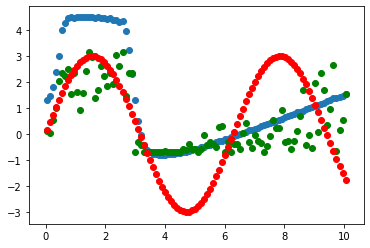

In [243]:
plt.scatter(x_test, pred_mean)
plt.scatter(x_test, standard.detach().numpy(), color='g')
plt.scatter(x_test, y_test, color='r')
plt.show()

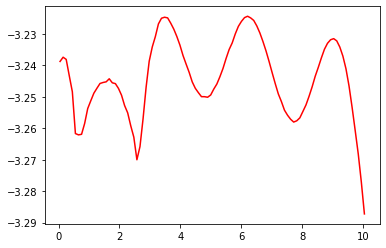

In [246]:
plt.plot(x_test, pred_var)
plt.plot(x_test, test_ll, color='r')
plt.show()